## Who is quoted in the media

In [2]:
import pandas as pd
from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"

In [3]:
# Plotting standards
plt.rc('axes', labelsize=14)   # fontsize of the x and y labels
plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=14)   # fontsize of the figure title
plt.rc('lines', markersize=7)
plt.rc('lines', linewidth=2)

### 0. Pre-process initial data, remove unused columns

In [4]:
speakers = pd.read_json('data/speakers.json.bz2', compression='bz2')
print(speakers.shape)
speakers.head(2)

(691122, 16)


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,n_unique_quotes,n_quotes
Q270316,"[Cynthia Jeanne Bowers, C. Jeanne Shaheen]",[+1947-01-28T00:00:00Z],[Q30],[Q6581072],1393026432,None,S001181,[Q82955],[Q29552],None,Jeanne Shaheen,None,item,[Q23540],4094,21060
Q1253,"[Ban Kimoon, Ban Ki Moon]",[+1944-06-13T00:00:00Z],[Q884],[Q6581097],1384825460,[Q484464],None,"[Q82955, Q193391]",[Q327591],None,Ban Ki-moon,None,item,"[Q9581, Q748]",12746,94704


In [15]:
# Drop the columns that don't add value to clustering (e.g. speaker name) and other attributes present in less than 50% of the speakers
speakers_dropped = speakers.drop(columns=['label', 'US_congress_bio_ID', 
                                          'lastrevid', 'type', 
                                          'candidacy', 'academic_degree',
                                          'religion',
                                          'ethnic_group', 'party']).dropna(axis=0)
# Add the age from the date-of-birth column
ages = []
for birth in speakers_dropped.date_of_birth.values:
    if not birth is None:
        ages.append(datetime.now().year - int(birth[0][1:5]))
    else:
        ages.append(None)

speakers_dropped['age'] = ages
speakers_dropped.head(2)

# Remove the date_of_birth column
speakers_features = speakers_dropped.drop(columns=['date_of_birth']).dropna(axis=0)

# Keep only the first instance of occupation, nationality and gender
speakers_features_full = pd.DataFrame()
speakers_features_full['n_quotes'] = speakers_features['n_quotes']
speakers_features_full['n_unique_quotes'] = speakers_features['n_unique_quotes']
speakers_features_full['age'] = speakers_features['age']

for name, values in speakers_features.iteritems():
    if name not in ['n_quotes', 'n_unique_quotes', 'age']:
        updated_values = []
        for val in values:
            if not val is None:
                updated_values.append(val[0])
            else:
                updated_values.append(None)
        speakers_features_full[name] = updated_values

speakers_features_preprocessed = speakers_features_full.dropna(axis=0) # remove row if any column value is None

# Only keep the speakers with age within [0, 150]
speakers_features_final = speakers_features_preprocessed[(speakers_features_preprocessed.age > 0) 
                                                               & (speakers_features_preprocessed.age < 150)]
print(speakers_features_final.shape)
speakers_features_final.head(2)

# Reduce genders to male, female and others
map_gender = lambda gender: gender if (gender == 'Q6581097' or gender == 'Q6581072') else 'Other'
reduced_genders = speakers_features_final['gender'].map(map_gender)

speakers_features_final['gender'] = reduced_genders

(101351, 7)


<ipython-input-15-b1936749281a>:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
speakers_features_final.head(2)

,n_quotes,n_unique_quotes,age,aliases,nationality,gender,occupation
Q270316,21060,4094,74,Cynthia Jeanne Bowers,Q30,Q6581072,Q82955
Q1253,94704,12746,77,Ban Kimoon,Q884,Q6581097,Q82955


### 1. Authors vs n_quotes 

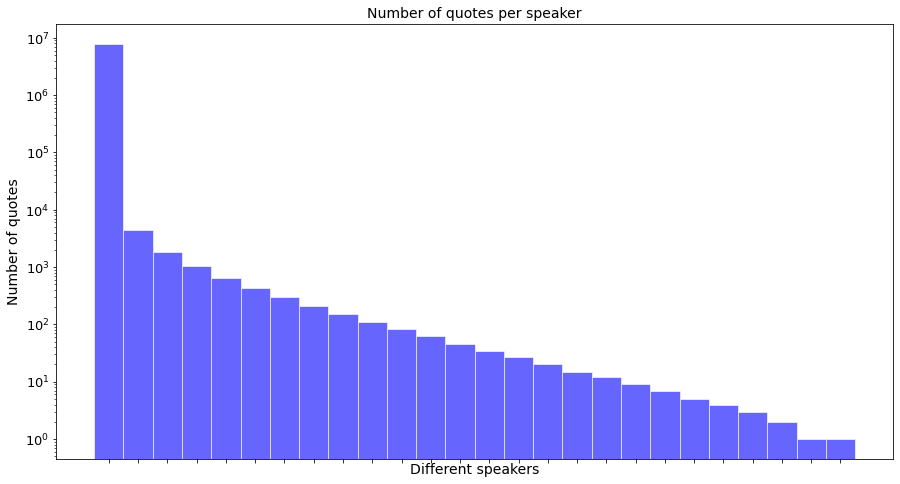

In [19]:
fig = plt.figure(figsize=(15,8))
speakers_sorted = speakers_features_final.sort_values(by=['n_quotes'], ascending=False)
plt.bar(speakers_sorted.n_quotes.keys().tolist()[0:-1:4_000], 
        speakers_sorted.n_quotes.values.tolist()[0:-1:4_000], 
        align='center', width=1, alpha=0.6, facecolor='blue', edgecolor='w', log=True)
plt.tick_params(axis='x',labelbottom=False, pad=5)
plt.xlabel('Different speakers')
plt.ylabel('Number of quotes')
plt.title('Number of quotes per speaker')
plt.show()

In [36]:
color_discrete_map={
    "male":"blue", 
    "female":"red"}

fig = px.histogram(x=speakers_sorted.aliases.tolist()[0:-1:700],
                   y=speakers_sorted.n_quotes.values.tolist()[0:-1:700],
                   title=f"Number of quotations per speaker",
                   log_y=True)
fig.update_layout(yaxis_title="Number of quotations", xaxis_title="")
fig.update_xaxes(type='category')
fig.update_layout(
    template=None,
    font_family='Nunito',
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
    )
)
fig.show()
fig.write_html("data/images/quotations_per_speaker.html")

### 2. Gender visualization

In [48]:
count = speakers_features_final.gender.value_counts()
count
percentage_men = count['Q6581097'] / count.sum()
percentage_women = count['Q6581072'] / count.sum()
percentage_rest = count['Other'] / count.sum()    
print(f'Men: {100*percentage_men}% \nWomen: {100*percentage_women}\nRest: {100*percentage_rest}')

Men: 76.92384304582546% 
Women: 22.95324648867662
Rest: 0.1229104654979232


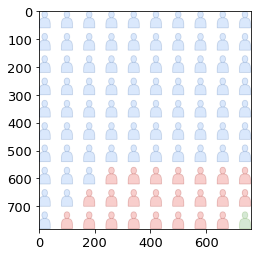

In [49]:
import matplotlib.image as mpimg
img = mpimg.imread('data/images/infogender_white.png')
imgplot = plt.imshow(img)
plt.show()

### 3. Occupations for all, men, and women